In [48]:
from tst import Transformer
import pandas as pd

original_data_path = "../data/main.csv"
df = pd.read_csv(original_data_path)
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,open,high,low,close,volume,average,barCount,negative,neutral,positive,DFF,DTB3,DGS10,DFII10,DGS1,DGS2,DGS5,DFII5,BAMLH0A0HYM2
0,2022-12-27,3986.00,3986.00,3986.00,3986.00,1.0,3986.00,1,0.096508,0.679061,0.224432,4.33,4.35,3.84,1.58,4.75,4.32,3.94,1.61,4.55
1,2022-12-28,3955.00,3955.00,3955.00,3955.00,1.0,3955.00,1,0.076432,0.660771,0.262796,4.33,4.35,3.88,1.60,4.71,4.31,3.97,1.64,4.77
2,2022-12-29,4015.00,4015.00,4009.00,4009.00,7.0,4011.15,5,0.065120,0.656600,0.278280,4.33,4.34,3.83,1.56,4.71,4.34,3.94,1.62,4.81
3,2022-12-30,3998.25,3998.25,3998.25,3998.25,0.0,3998.25,0,0.092447,0.629921,0.277632,4.33,4.30,3.88,1.58,4.73,4.41,3.99,1.66,4.79
4,2023-01-03,3982.00,3982.00,3982.00,3982.00,0.0,3982.00,0,0.084405,0.664180,0.251415,4.33,4.40,3.79,1.53,4.72,4.40,3.94,1.65,4.70


In [49]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import ta

# Assuming your DataFrame is named 'df' and contains 'close', 'volume', 'high', and 'low' columns
df['index'] = df.index.astype(int)
df['log_volume'] = np.log(df['volume'] + 1)
df['pct_change'] = df['close'].pct_change()
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# add indicators
df['sma_10'] = ta.trend.sma_indicator(df['close'], window=10)
df['sma_30'] = ta.trend.sma_indicator(df['close'], window=30)
df['ema_10'] = ta.trend.ema_indicator(df['close'], window=10)
df['ema_30'] = ta.trend.ema_indicator(df['close'], window=30)
df['rsi'] = ta.momentum.rsi(df['close'], window=14)
df['macd'] = ta.trend.macd(df['close'], window_slow=26, window_fast=12)
df['macd_signal'] = ta.trend.macd_signal(df['close'], window_slow=26, window_fast=12)
df['macd_diff'] = ta.trend.macd_diff(df['close'], window_slow=26, window_fast=12)
df['bollinger_high'] = ta.volatility.bollinger_hband(df['close'], window=20, window_dev=2)
df['bollinger_low'] = ta.volatility.bollinger_lband(df['close'], window=20, window_dev=2)
df['stoch'] = ta.momentum.stoch(df['high'], df['low'], df['close'], window=14, smooth_window=3)
df['stoch_signal'] = ta.momentum.stoch_signal(df['high'], df['low'], df['close'], window=14, smooth_window=3)
df['adx'] = ta.trend.adx(df['high'], df['low'], df['close'], window=14)

# get the target
df['next_close'] = df['close'].shift(-1)
df['next_pct_change'] = df['pct_change'].shift(-1)

# 1_day_decision
df['1_day_decision'] = df['next_close'] > df['close']
# turn the boolean into 1 and 0
df['1_day_decision'] = df['1_day_decision'].astype(int)


#columns_to_ignore = ['index', 'date', 'next_close', 'close', 'open', 'high', 'low', 'average']
columns_to_ignore = ['index', 'date', 'next_close', 'next_pct_change', '1_day_decision']
target_column = '1_day_decision'

# Drop any missing values from the DataFrame
data = df.dropna()

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Prepare the data for linear regression
# everything except date and next_close
features = data.drop(columns=columns_to_ignore).columns
target = target_column

# Split the data into training, validation, and testing sets
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

# Scale the features and target using only the training data
scaler_features = StandardScaler()
train_features = scaler_features.fit_transform(train_data[features])
val_features = scaler_features.transform(val_data[features])
test_features = scaler_features.transform(test_data[features])

scaler_target = StandardScaler()
train_target = scaler_target.fit_transform(train_data[[target]])
val_target = scaler_target.transform(val_data[[target]])
test_target = scaler_target.transform(test_data[[target]])

# Create the input sequences and corresponding labels for the LSTM model
def create_sequences(features, target, seq_length):
    X = []
    y = []
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Number of previous days to use as input
X_train, y_train = create_sequences(train_features, train_target, seq_length)
X_val, y_val = create_sequences(val_features, val_target, seq_length)
X_test, y_test = create_sequences(test_features, test_target, seq_length)

In [51]:
print('X_train: ',X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test',y_test.shape)

X_train:  (178, 10, 37) X_test (31, 10, 37) y_train (178, 1) y_test (31, 1)


In [52]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)  # Transposing to match model's input shape
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

print(X_train_tensor)

tensor([[[-0.4558, -0.4918, -0.3995,  ...,  0.7364,  0.5190,  0.9954],
         [-0.3854, -0.4228, -0.3273,  ...,  0.9524,  0.8893,  0.9828],
         [-0.7111, -0.7421, -0.6611,  ..., -0.0470,  0.5978,  0.8299],
         ...,
         [-1.3929, -1.4104, -1.3599,  ..., -1.5332, -1.5531,  0.0785],
         [-1.3280, -1.3468, -1.2934,  ..., -1.3665, -1.4925, -0.0322],
         [-1.3998, -1.4172, -1.3670,  ..., -1.5332, -1.6076, -0.1106]],

        [[-0.3854, -0.4228, -0.3273,  ...,  0.9524,  0.8893,  0.9828],
         [-0.7111, -0.7421, -0.6611,  ..., -0.0470,  0.5978,  0.8299],
         [-0.7829, -0.8124, -0.7347,  ..., -1.0943, -0.0668,  0.6594],
         ...,
         [-1.3280, -1.3468, -1.2934,  ..., -1.3665, -1.4925, -0.0322],
         [-1.3998, -1.4172, -1.3670,  ..., -1.5332, -1.6076, -0.1106],
         [-1.5047, -1.5200, -1.4745,  ..., -1.5332, -1.6076, -0.1477]],

        [[-0.7111, -0.7421, -0.6611,  ..., -0.0470,  0.5978,  0.8299],
         [-0.7829, -0.8124, -0.7347,  ..., -1

In [53]:
print(y_train_tensor)

tensor([[ 0.9686],
        [ 0.9686],
        [ 0.9686],
        [-1.0324],
        [ 0.9686],
        [-1.0324],
        [-1.0324],
        [-1.0324],
        [ 0.9686],
        [-1.0324],
        [ 0.9686],
        [-1.0324],
        [ 0.9686],
        [ 0.9686],
        [-1.0324],
        [ 0.9686],
        [ 0.9686],
        [ 0.9686],
        [-1.0324],
        [ 0.9686],
        [ 0.9686],
        [ 0.9686],
        [ 0.9686],
        [-1.0324],
        [-1.0324],
        [ 0.9686],
        [ 0.9686],
        [ 0.9686],
        [-1.0324],
        [ 0.9686],
        [-1.0324],
        [ 0.9686],
        [ 0.9686],
        [-1.0324],
        [-1.0324],
        [-1.0324],
        [ 0.9686],
        [-1.0324],
        [-1.0324],
        [ 0.9686],
        [ 0.9686],
        [ 0.9686],
        [-1.0324],
        [-1.0324],
        [-1.0324],
        [ 0.9686],
        [ 0.9686],
        [-1.0324],
        [ 0.9686],
        [-1.0324],
        [-1.0324],
        [ 0.9686],
        [-1.

In [54]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create a DataLoader for training data
batch_size = 64  # Adjust the batch size as needed
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Transformer(
  (layers_encoding): ModuleList(
    (0-3): 4 x Encoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=32, out_features=64, bias=True)
        (_W_k): Linear(in_features=32, out_features=64, bias=True)
        (_W_v): Linear(in_features=32, out_features=64, bias=True)
        (_W_o): Linear(in_features=64, out_features=32, bias=True)
      )
      (_feedForward): PositionwiseFeedForward(
        (_linear1): Linear(in_features=32, out_features=2048, bias=True)
        (_linear2): Linear(in_features=2048, out_features=32, bias=True)
      )
      (_layerNorm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (_layerNorm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (_dopout): Dropout(p=0.1, inplace=False)
    )
  )
  (layers_decoding): ModuleList(
    (0-3): 4 x Decoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=32, out_features=64, bias=True)
        (_W_k): Linear(in_features=3

[Epoch  20/20]: 100%|██████████| 178/178 [00:00<00:00, 408.26it/s, loss=0.754]


Training complete.


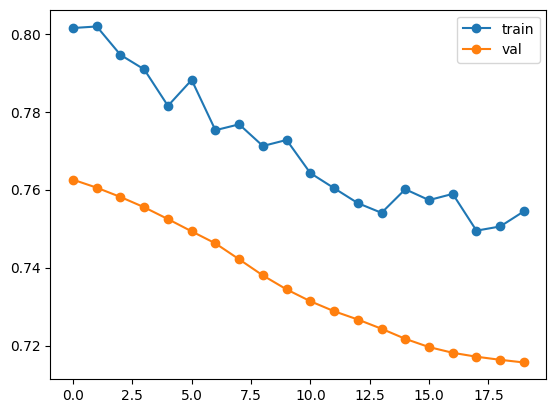

In [55]:
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

d_input = 37 # this one should be 4 assume it is 'Volume','Open', 'Close', 'Scaled_sentiment'
d_output = 1 # prediction length be 3, this is confirmed
d_model = 32 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = 30 # Attention window size
dropout = 0.1 # Dropout rate
pe = 'regular' # Positional encoding
chunk_mode = None
# Creating sequences
epochs = 20

# Creating the model
model = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
# model = TimeSeriesTransformer(num_features, num_outputs, dim_val, n_heads, n_decoder_layers, dropout_rate).to(device)
print(model)
# Loss function and optimizer
loss_function = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# # Training parameters
# num_batches = int(len(X_train) / batch_size)

# # Training loop
# model.train()
# for epoch in range(epochs):
#   total_loss = 0
#   with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {epoch+1:3d}/{epochs}]") as pbar:
#     for b, (x, y) in enumerate(dataloader_train):
#         start_index = b * batch_size
#         end_index = start_index + batch_size
#         x_batch = X_train_tensor[start_index:end_index]
#         y_batch = y_train_tensor[start_index:end_index]

#         # print('x_batch',x_batch.shape)
#         # print('y_batch',y_batch.shape)

#         # Forward pass
#         y_pred = model(x_batch)

#         # print('y_pred',y_pred.shape)

#         loss = loss_function(y_pred, y_batch)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#   print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / num_batches}")

# print("Training complete.")

model.train()
# Prepare loss history
train_hist_loss = np.zeros(epochs)
val_hist_loss = np.zeros(epochs)

for idx_epoch in range(epochs):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{epochs}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()
            # Propagate input
            netout = model(x.to(device))

            # Compute loss
            loss = loss_function(y.to(device), netout)

            # Backpropagate loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
        train_loss = running_loss/len(dataloader_train)
        pbar.set_postfix({'loss': train_loss})
        
        train_hist_loss[idx_epoch] = train_loss
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in dataloader_val:
                y_pred_val = model(x_val.to(device))
                val_loss += loss_function(y_val.to(device), y_pred_val).item()
        val_loss /= len(dataloader_val)
        val_hist_loss[idx_epoch] = val_loss
        
        model.train()
        
print("Training complete.")

plt.plot(train_hist_loss, 'o-', label='train')
plt.plot(val_hist_loss, 'o-', label='val')
plt.legend()
plt.show()

c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Test set evaluation:
Accuracy: 0.52
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.52      1.00      0.68        16

    accuracy                           0.52        31
   macro avg       0.26      0.50      0.34        31
weighted avg       0.27      0.52      0.35        31



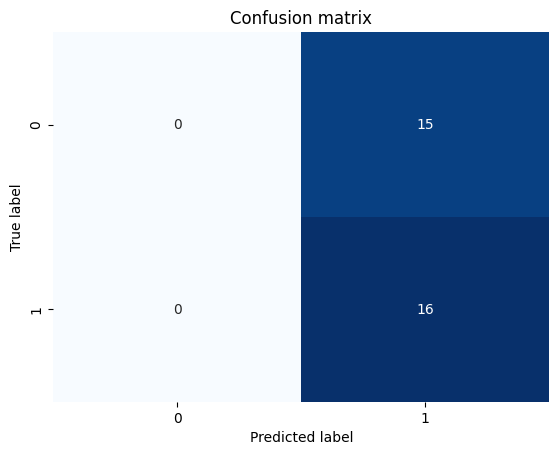

In [56]:
# Evaluate the model on the test set
model.eval()
y_pred_list = []
with torch.no_grad():
    for x_test, _ in dataloader_test:
        y_pred = model(x_test.to(device))
        y_pred_list.append(y_pred.cpu().numpy())

y_pred_arr = np.concatenate(y_pred_list, axis=0)
y_pred_arr = y_pred_arr.reshape(-1)

# Reverse scaling of the predicted values
y_pred_scaled = scaler_target.inverse_transform(y_pred_arr.reshape(-1, 1)).flatten()

# Apply a threshold to convert predicted probabilities to binary labels
threshold = 0.5
y_pred_binary = (y_pred_scaled > threshold).astype(int)

# Convert true labels to binary format
y_test_binary = scaler_target.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1)).flatten().astype(int)

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_test_binary, y_pred_binary)
classification_rep = classification_report(y_test_binary, y_pred_binary)

print("Test set evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print(classification_rep)

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()